In [1]:
from Function.Function import *
from os.path import abspath , join
current_folder =abspath('');current_folder



Using TensorFlow backend.


'D:\\jupyter\\Project_796'

# Preprocessing data

In [2]:
period = 400 #  days for train
period_valid = 400 # days for test
stock ,spy =get_data(period,period_valid)

# Construct model

In [3]:
dimension_of_input  = len(stock['calibrate']['lp'].columns) # number of stock
autoencoder = inital_model(dimension_of_input)
# train model
# we use net difference to train model
data = stock['calibrate']['net']
#nomalization standardlization
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)

In [4]:
autoencoder.save(join(current_folder,'Models/com_autoencoder_{}.h5'.format(period)))

# Predict and Pick the stocks

In [18]:
path = join(current_folder,'Models/best/com_autoencoder_{}.h5'.format(period))
autoencoder = load_model(path)
data = stock['calibrate']['net']
predict = autoencoder.predict(data) 
# use different error measure to decide which stocks are market followers which are not

# we need to figure out what is the best error measure,?

# sum absolute relative error
communal_information = np.sum(np.absolute((stock['calibrate']['net'] - predict)/predict),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : data.columns[ranking] })
ranks

,communal,index
BKNG,156.643172,BKNG
NVR,344.015469,NVR
AMCR,694.805027,AMCR
GOOG,823.878818,GOOG
PBCT,910.442876,PBCT
...,...,...
BWA,29944.661294,BWA
ES,31608.930117,ES
DLR,46128.793588,DLR
HUM,51988.033261,HUM


# Let see what the best one looks like

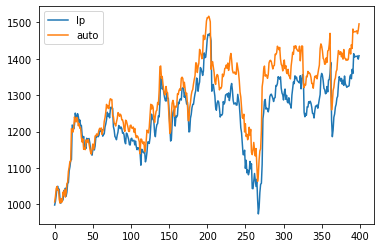

In [6]:
index = ranking[0]
stock_autoencoder = copy.deepcopy(predict[:, index]);stock_autoencoder
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, index])
## plot for comparison
plt.plot(np.array(stock['calibrate']['lp'].iloc[:, index]),label = 'lp')
plt.plot(stock_autoencoder,label = 'auto')
plt.legend()


# Calibriation for reproducing the market after dimension reduction

In [7]:
spy_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)
non = np.array([15, 35, 55]) # numbrt of non_communal ??
initial = 50 # number of market follower  ??

# test different number of non_communal
for non_communal in non:  
    s = initial + non_communal # dimension of inputs, number of stocks
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # set the index of portoflio
    
    
    # inital model
    autoencoder = inital_model_portfolio(s)
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = spy['calibrate']['percentage']
    # normalize the data ( clean)
    dl_scaler[s] = StandardScaler()     
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    autoencoder.fit(x, y, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)    # fit the model
    autoencoder.save(join(current_folder,'Models/trained_autoencoder{}.h5'.format(s)))
    
    #calculate the error
    relative_percentage = copy.deepcopy(autoencoder.predict(x))/100 + 1
    
    
    spy_predict['calibrate'][s] = spy['calibrate']['lp'].iloc[0,0] * np.concatenate([[1],(relative_percentage.cumprod())])          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm(np.array(spy_predict['calibrate'][s]) - np.array(spy['calibrate']['lp']))

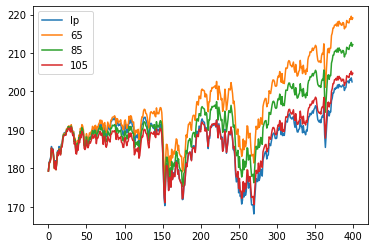

In [8]:
# plot results 
plt.plot(np.array(spy['calibrate']['lp'] ), label = 'lp')

for s in (initial + non):
   
    plt.plot(np.array(spy_predict['calibrate'][s] ), label = '{}'.format(s))
plt.legend()

In [9]:
print(total_2_norm_diff['calibrate'])

defaultdict(None, {65: 5795.8231768214655, 85: 4629.917257756677, 105: 3938.779833354628})


# validating out of sample

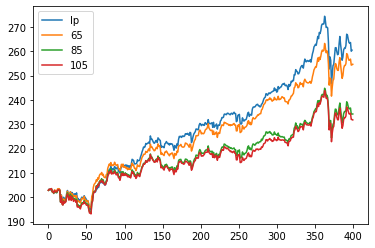

In [12]:
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model(join(current_folder,'Models/trained_autoencoder{}.h5'.format(s)))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = (relative_percentage /100) + 1
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * np.concatenate([[1],(relative_percentage.cumprod())])       
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'lp')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()

# Beat the market

In [13]:
spy_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)
non = np.array([15, 35, 55]) # numbrt of non_communal ??
initial = 50 # number of market follower  ??
y = copy.deepcopy (spy['calibrate']['percentage'])
# we change the the path of y and ask
y[y < -1] = 1


In [14]:
# test different number of non_communal
for non_communal in non:  
    encoding_dim = 128 
    s = initial + non_communal # dimension of inputs, number of stocks
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # set the index of portoflio
    
    
    #  initial model
    autoencoder = inital_model_portfolio(s)
        
    x = stock['calibrate']['percentage'].iloc[:, stock_index]

    # normalize the data ( clean)
    dl_scaler[s] = StandardScaler()     
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    autoencoder.fit(x, y, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)    # fit the model
    autoencoder.save(join(current_folder,'Models/beat_market_autoencoder{}.h5'.format(s)))
    
    #calculate the error
    relative_percentage = copy.deepcopy(autoencoder.predict(x))
    
    relative_percentage = (relative_percentage/100 ) + 1
    
    spy_predict['calibrate'][s] = spy['calibrate']['lp'].iloc[0,0] * np.concatenate([[1],relative_percentage.cumprod()])  
    total_2_norm_diff['calibrate'][s] = np.linalg.norm(np.array(spy_predict['calibrate'][s]) - np.array(spy['calibrate']['lp']))

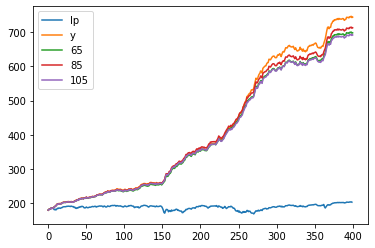

In [15]:
ypath = spy['calibrate']['lp'].iloc[0,0] * np.concatenate([[1],np.array((y/100)+1).cumprod()])  
# plot result
plt.plot(np.array(spy['calibrate']['lp'] ), label = 'lp')
plt.plot(ypath,label= 'y')
for s in (initial + non): 
    plt.plot(np.array(spy_predict['calibrate'][s] ), label = '{}'.format(s))
plt.legend()

# The last ( real world) 
# Validating

In [16]:
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model(join(current_folder,'Models/beat_market_autoencoder{}.h5'.format(s)))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = (relative_percentage /100) + 1
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

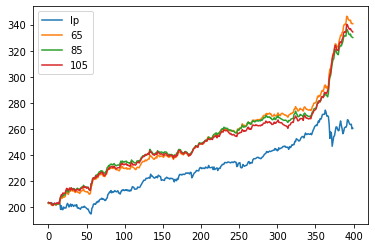

In [17]:
# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'lp')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()